# Feature Map Correlation

Measures the correlation between ground truth segmentations of organelles and the filters in the last convolutional layer of a ResNet50. Uses this information to "naively" derive a segmentation.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, pdb, math
import numpy as np
import torch
import torch.nn as nn
from scipy.stats.mstats import pointbiserialr
from matplotlib import pyplot as plt

In [3]:
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2

In [4]:
from _helpers import *

In [5]:
#pick an example (index can be 0-7)
index = 2

#get the best downsampling factor
downsample_factors = [4, 4, 16, 2, 8, 4, 8, 4]

#define the device that we're using
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#load the cellemnet and imagenet moco pretrained models
cellemnet, cellemnet_norms = load_moco_pretrained(dataset='cellemnet')
imagenet, _ = load_moco_pretrained(dataset='imagenet')

#change the strides in the resnet layers such that
#the output feature maps will be larger or smaller
#adjust this based on the size of the target structure
#for mitochondria-sized objects a downsampling factor of
#8 is a good place to start
cellemnet = restride_resnet(cellemnet, downsample_factor=downsample_factors[index])
imagenet = restride_resnet(imagenet, downsample_factor=downsample_factors[index])

#next we want to remove the average pooling and
#fully connected layers (i.e. the last 2 layers), such that 
#the output layer will be layer4 of the resnet
cellemnet = nn.Sequential(*list(cellemnet.children())[:-2])
imagenet = nn.Sequential(*list(imagenet.children())[:-2])

#move the models to devices and set to eval mode
cellemnet = cellemnet.to(device).eval()
imagenet = imagenet.to(device).eval()

In [6]:
#create cellemnet transforms
cellemnet_aug = Compose([
    Resize(224, 224),
    Normalize(mean=cellemnet_norms[0], std=cellemnet_norms[1]),
    ToTensorV2()
])

#create imagenet transforms
imagenet_aug = Compose([
    Resize(224, 224),
    Normalize(), #default normalization values are for ImageNet
    ToTensorV2()
])

#make the dataset classes
cellemnet_data = CorrelationData('example_data/correlation/', tfs=cellemnet_aug, gray_channels=1)
imagenet_data = CorrelationData('example_data/correlation/', tfs=imagenet_aug, gray_channels=3)

Found 8 images in example_data/correlation/images
Found 8 images in example_data/correlation/images


In [7]:
#get the num_filters filters most correlated with the
#labelmap and create a new filter that is their average response
num_filters = 32

#set the threshold for feature response
#to create a binarized "correlated" segmentation
thr = 0.3

#load the images and masks
#first cellemnet
data = cellemnet_data[index]
cellemnet_image, cellemnet_mask = data['image'], data['mask']

cellemnet_corrs = correlated_filters(cellemnet, cellemnet_image.to(device), cellemnet_mask)
#it's possible to get NaN correlations if a filter has no response anywhere
#just reset those to 0s
cellemnet_corrs = np.nan_to_num(cellemnet_corrs)
topk_indices = torch.topk(torch.from_numpy(cellemnet_corrs), num_filters).indices.to(device)
cellemnet_topk_mean_fmap = mean_topk_map(cellemnet, cellemnet_image.to(device), topk_indices, rescale=True)
#measure the pb correlation between this "mean response" and the ground truth
cellemnet_rpb = pointbiserialr(cellemnet_mask.numpy().ravel(), cellemnet_topk_mean_fmap.ravel())[0]
#measure iou between "correlated segmentation" and ground truth
cellemnet_iou = binary_iou((cellemnet_topk_mean_fmap > thr).astype(np.uint8), cellemnet_mask.numpy())

#then imagenet
data = imagenet_data[index]
imagenet_image, imagenet_mask = data['image'], data['mask']

#now the same for imagenet
imagenet_corrs = correlated_filters(imagenet, imagenet_image.to(device), imagenet_mask)
imagenet_corrs = np.nan_to_num(imagenet_corrs)
topk_indices = torch.topk(torch.from_numpy(imagenet_corrs), num_filters).indices.to(device)
imagenet_topk_mean_fmap = mean_topk_map(imagenet, imagenet_image.to(device), topk_indices, rescale=True)
imagenet_rpb = pointbiserialr(imagenet_mask.numpy().ravel(), imagenet_topk_mean_fmap.ravel())[0]
imagenet_iou = binary_iou((imagenet_topk_mean_fmap > thr).astype(np.uint8), imagenet_mask.numpy())

/data/conradrw/conda/lib/python3.7/site-packages/scipy/stats/mstats_basic.py:776: RuntimeWarning: invalid value encountered in double_scalars
  rpb = (y1m - y0m)*np.sqrt(phat * (1-phat)) / y.std()


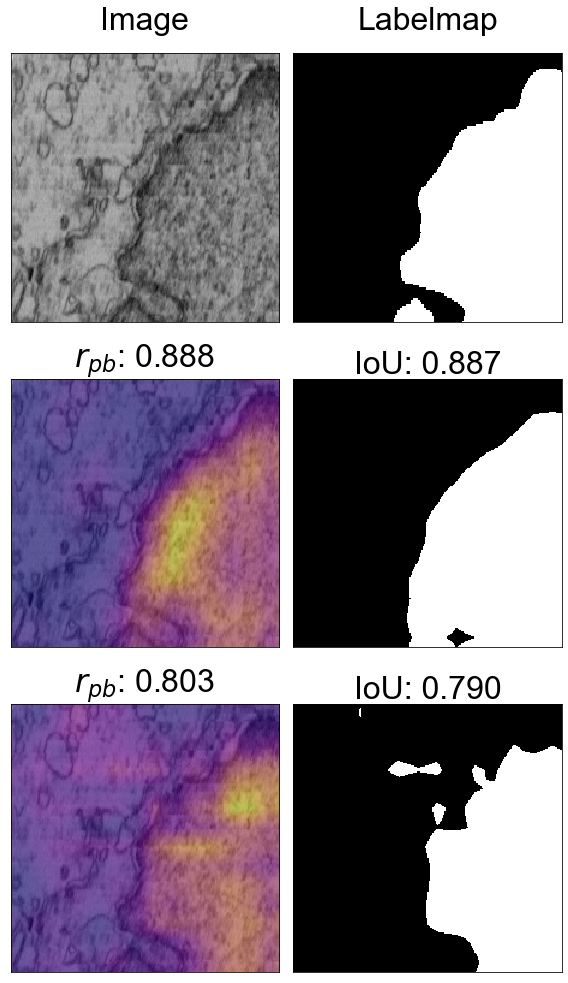

In [8]:
f, ax = plt.subplots(3, 2, figsize=(8, 14))

cmap = 'plasma'

#plot the image, labelmap, mean_topk_map, and binarized mean_topk_map
#for both cellemnet and imagnet
ax[0, 0].set_title('Image', fontsize=32, fontname='Arial', pad=24)
ax[0, 0].imshow(cellemnet_image[0], cmap='gray')
ax[0, 1].set_title('Labelmap', fontsize=32, fontname='Arial', pad=24)
#ax[0, 1].imshow(cellemnet_image[0], cmap='gray')
ax[0, 1].imshow(cellemnet_mask, alpha=1, cmap='gray')
ax[1, 0].set_title('$r_{pb}$: ' + f'{cellemnet_rpb:.3f}', fontsize=32, fontname='Arial')
ax[1, 0].imshow(cellemnet_image[0], cmap='gray')
ax[1, 0].imshow(cellemnet_topk_mean_fmap, alpha=0.5, cmap=cmap)
ax[1, 1].set_title(f'IoU: {cellemnet_iou:.3f}', fontsize=32, fontname='Arial')
#ax[1, 1].imshow(cellemnet_image[0], cmap='gray')
ax[1, 1].imshow(cellemnet_topk_mean_fmap > thr, alpha=1, cmap='gray')

#now the same for imagenet
ax[2, 0].set_title('$r_{pb}$: ' + f'{imagenet_rpb:.3f}', fontsize=32, fontname='Arial')
ax[2, 0].imshow(imagenet_image[0], cmap='gray')
ax[2, 0].imshow(imagenet_topk_mean_fmap, alpha=0.5, cmap=cmap)
ax[2, 1].set_title(f'IoU: {imagenet_iou:.3f}', fontsize=32, fontname='Arial')
#ax[2, 1].imshow(imagenet_image[0], cmap='gray')
ax[2, 1].imshow(imagenet_topk_mean_fmap > thr, alpha=1, cmap='gray')

for a in f.axes:
    a.set_xticks([])
    a.set_yticks([])
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()